<a href="https://colab.research.google.com/github/AndersonMahecha/ReconocimientoDePlacas/blob/master/Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocesamiento
Aqui se crean las anotaciones para el procesamiento


In [0]:
import xml.etree.ElementTree as ET
from os import scandir, getcwd
import os as os
import cv2 as cv
import matplotlib.pyplot as plt


rootPath = "/content/gdrive/My Drive/Colab/Vision"

nuevopath=rootPath+"/Images"
pathEtiqueta = rootPath+"/Etiqueta"
path = rootPath+"/carros"
pathSalida = rootPath+ "/Annotation"
extencion = ".xml"
currentFolder = os.getcwd()

print("preprocesado Iniciado")
def ls(ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if arch.is_file()]

if not os.path.isdir(pathSalida):
    os.mkdir(pathSalida)
if not os.path.isdir(nuevopath):
    os.mkdir(nuevopath)

files = ls(pathEtiqueta)

for f in files:
    ext = os.path.splitext(f)[1]
    if ext==extencion:
        tree = ET.parse(pathEtiqueta+"/"+f)
        root = tree.getroot()
        flname = root.find("filename").text;
        image = cv.imread(path+"/"+flname)
        print("Nombre archivo "+flname)
        width = int(image.shape[1])
        height = int(image.shape[0])
        cv.rectangle(image,(0,0),(width,height),(0,0,0),-1)
        for placa in root.findall("object"):
            xmin = 0
            ymin = 0
            xmax = 0
            ymax = 0
            for pos in placa.find("bndbox"):
                
                if pos.tag == "xmin":
                    xmin = int(pos.text)
                if pos.tag == "ymin":
                    ymin = int(pos.text)
                if pos.tag == "xmax":
                    xmax = int(pos.text)
                if pos.tag == "ymax":
                    ymax = int(pos.text)
            cv.rectangle(image,(xmin,ymin),(xmax,ymax),(1,0,200),-1)
        image2 = cv.imread(path+"/"+flname)
        if image.shape[1]>512:
            scale_percent = image.shape[1]/512*100
            width = int(image.shape[1] * 100/scale_percent)
            height = int(image.shape[0] * 100/scale_percent)
            dim = (width, height)
            image = cv.resize(image, dim, interpolation = cv.INTER_AREA)
            image2 = cv.resize(image2, dim, interpolation = cv.INTER_AREA)
        imageGray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
        cv.imwrite(nuevopath+"/"+flname[:len(flname)-4]+"Gray"+".png",imageGray)
        cv.imwrite(pathSalida+"/"+flname[:len(flname)-4]+"Gray"+".png",image)
        cv.imwrite(nuevopath+"/"+flname[:len(flname)-4]+".png",image2)
        cv.imwrite(pathSalida+"/"+flname[:len(flname)-4]+".png",image)
print("preprocesado Terminado")

# Entrenamiento
Aqui se entrena la Red Neuronal

In [2]:
!pip install keras-segmentation
!pip install pillow
!sudo apt install tesseract-ocr
!pip install pytesseract

  Created wheel for keras-segmentation: filename=keras_segmentation-0.2.0-cp36-none-any.whl size=25694 sha256=bea8b68532a8896e8c3838c3a35d2bf6846bb61f2ce7530a6a11be1ce29d8ce2
  Stored in directory: /root/.cache/pip/wheels/10/43/34/8d5a4aaa8d4479380c3aef57abf90ac47aa1e062c772defa39
Successfully built keras-segmentation
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 8 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import keras_segmentation
rootPath = '/content/gdrive/My Drive/Colab/Vision'

model = keras_segmentation.models.unet.vgg_unet(n_classes=2,input_height=512,input_width=704)
model.train( 
    train_images =  rootPath+"/Images",
    train_annotations = rootPath+"/Annotation",
    checkpoints_path = rootPath+"/checkPoint" ,
    epochs=3
)

model.save(rootPath+"/model")
model.save_weights(rootPath+"/model.h5")

# CargaModelo
Aqui se carga el modelo generado en el paso anterior

In [4]:
import keras_segmentation
import os
from keras.models import load_model
import json

rootPath = '/content/gdrive/My Drive/Colab/Vision'
modelPath = rootPath+'/model.h5'
checkPointPath = rootPath+'/checkPoint'



def loadModel(checkPointPath, modelPath):
  model = keras_segmentation.predict.model_from_checkpoint_path(checkpoints_path=checkPointPath)
  model.load_weights(modelPath)
  return model


model = loadModel(checkPointPath,modelPath)




Using TensorFlow backend.






58892288/58889256 [==============================] - 1s 0us/step




loaded weights  /content/gdrive/My Drive/Colab/Vision/checkPoint.2


# Procesar imagenes
Primero debe correrse la carga del modelo

cv2.imwrite(salida+"/recortada.png",recortada*255)
recortadaGray = cv2.imread(salida+"/recortada.png",0)
blackAndWhiteImage = cv2.adaptiveThreshold(recortadaGray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 3, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLACA: DLX:655


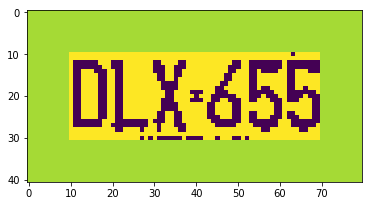

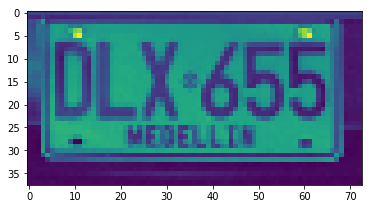

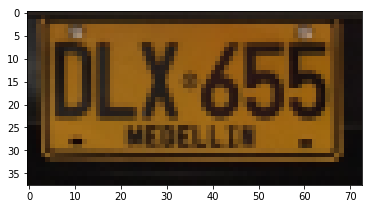

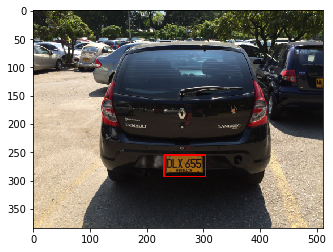

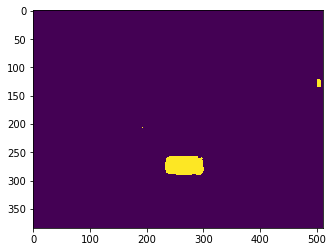

In [5]:
import cv2 as cv2
import matplotlib.pyplot as plt
from os import scandir, getcwd
import os as os
import numpy as np

from PIL import Image
import pytesseract

rootPath = '/content/gdrive/My Drive/Colab/Vision'
salida = rootPath+"/temp"
salidaPrediccion = salida+"/out.jpeg"
salidaPlaca = salida+"/recortada.png"
salidaBN = salida+"/placa.png"

if not os.path.isdir(salida):
    os.mkdir(salida)


imgToProc ="/content/gdrive/My Drive/Colab/Vision/Images/carro (135).png"
original=plt.imread(fname=imgToProc)

img = model.predict_segmentation(
    inp=imgToProc,
    out_fname=salidaPrediccion
)

img = cv2.imread(salidaPrediccion)

rgB=np.matrix(img[:,:,0])
rGb=np.matrix(img[:,:,1])

img=cv2.absdiff(rGb,rgB)
    
[fil,col]=img.shape
for i in range(0,fil):
    for j in range(0,col):
        if img[i,j,]<80:
            img[i,j]=0
for i in range(0,fil):
    for j in range(0,col):
        if img[i,j]>0:
            img[i,j]=1

se=np.ones((5,5), np.uint8)
se2=np.ones((5,5),np.uint8)
closing=cv2.morphologyEx(img,cv2.MORPH_CLOSE,se)
dilation=cv2.dilate(closing, se2,1)
a,contours,hierarchy=cv2.findContours(dilation,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt=contours[:]
num=len(cnt)
box=np.zeros((num,4))

for i in range(0,num):
  box[i,:]=cv2.boundingRect(cnt[i])
  L=np.zeros((num,4))
  Max=[0,0]
  for i in range (0,num):
    L[i,:]=box[i]
    if L[i,2]>Max[1]:
      Max=[i,L[i,2]]
BOX=box[Max[0],:]
BOX=np.array(BOX,dtype = np.uint32)
recortada=original[BOX[1]:BOX[1]+BOX[3],BOX[0]:BOX[0]+BOX[2],:].copy()
cv2.rectangle(original,(BOX[0],BOX[1]),(BOX[0]+BOX[2],BOX[1]+BOX[3]),(255,0,0),2)

cv2.imwrite(salidaPlaca,recortada*255)
recortadaGray = cv2.imread(salidaPlaca, 0)

recortadaGray = cv2.medianBlur(recortadaGray,1)
blackAndWhiteImage = cv2.adaptiveThreshold(recortadaGray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 7)

[x,y] = blackAndWhiteImage.shape
blackAndWhiteImage = blackAndWhiteImage[int(x*0.15):int(x*0.7),int(y*0.07):int(y*0.9)]

row, col = blackAndWhiteImage.shape[:2]
bottom = blackAndWhiteImage[row-2:row, 0:col]
mean = cv2.mean(bottom)[0]

bordersize = 10
blackAndWhiteImage = cv2.copyMakeBorder(
    blackAndWhiteImage,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[mean, mean, mean]
)

cv2.imwrite(salidaBN, blackAndWhiteImage)
text = pytesseract.image_to_string(Image.open(salidaBN))

os.remove(salidaBN)
os.remove(salidaPlaca)
os.remove(salidaPrediccion)

print("PLACA: "+text)

plt.imshow(blackAndWhiteImage)
plt.figure()
plt.imshow(recortadaGray)
plt.figure()
plt.imshow(recortada)
plt.figure()
plt.imshow(original)
plt.figure()
plt.imshow(img)
plt.show()
